In [49]:
import mmbra
import mmbracategories

## Data loading

In [50]:
import torch
import os
import scipy.io as sio
from sklearn.model_selection import train_test_split
import numpy as np

# load data
data_dir_root = os.path.join('./data', 'ThingsEEG-Text')
sbj = 'sub-10'
image_model = 'pytorch/cornet_s'
text_model = 'CLIPText'
roi = '17channels'
brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
image_dir_seen = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
image_dir_unseen = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
text_dir_seen = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)
text_dir_unseen = os.path.join(data_dir_root, 'textual_feature/ThingsTest/text', text_model, sbj)

brain_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
brain_seen = brain_seen[:,:,27:60] # 70ms-400ms
brain_seen = np.reshape(brain_seen, (brain_seen.shape[0], -1))
image_seen = sio.loadmat(os.path.join(image_dir_seen, 'feat_pca_train.mat'))['data'].astype('double')*50.0
text_seen = sio.loadmat(os.path.join(text_dir_seen, 'text_feat_train.mat'))['data'].astype('double')*2.0
label_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
image_seen = image_seen[:,0:100]

brain_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double')*2.0
brain_unseen = brain_unseen[:, :, 27:60]
brain_unseen = np.reshape(brain_unseen, (brain_unseen.shape[0], -1))
image_unseen = sio.loadmat(os.path.join(image_dir_unseen, 'feat_pca_test.mat'))['data'].astype('double')*50.0
text_unseen = sio.loadmat(os.path.join(text_dir_unseen, 'text_feat_test.mat'))['data'].astype('double')*2.0
label_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['class_idx'].T.astype('int')
image_unseen = image_unseen[:, 0:100]

brain_seen = torch.from_numpy(brain_seen)
brain_unseen = torch.from_numpy(brain_unseen)
image_seen = torch.from_numpy(image_seen)
image_unseen = torch.from_numpy(image_unseen)
text_seen = torch.from_numpy(text_seen)
text_unseen = torch.from_numpy(text_unseen)
label_seen = torch.from_numpy(label_seen)
label_unseen = torch.from_numpy(label_unseen)

print('seen_brain_samples=', brain_seen.shape[0], ', seen_brain_features=', brain_seen.shape[1])
print('seen_image_samples=', image_seen.shape[0], ', seen_image_features=', image_seen.shape[1])
print('seen_text_samples=', text_seen.shape[0], ', seen_text_features=', text_seen.shape[1])
print('seen_label=', label_seen.shape)
print('unseen_brain_samples=', brain_unseen.shape[0], ', unseen_brain_features=', brain_unseen.shape[1])
print('unseen_image_samples=', image_unseen.shape[0], ', unseen_image_features=', image_unseen.shape[1])
print('unseen_text_samples=', text_unseen.shape[0], ', unseen_text_features=', text_unseen.shape[1])
print('unseen_label=', label_unseen.shape)

seen_brain_samples= 16540 , seen_brain_features= 561
seen_image_samples= 16540 , seen_image_features= 100
seen_text_samples= 16540 , seen_text_features= 512
seen_label= torch.Size([16540, 1])
unseen_brain_samples= 16000 , unseen_brain_features= 561
unseen_image_samples= 16000 , unseen_image_features= 100
unseen_text_samples= 16000 , unseen_text_features= 512
unseen_label= torch.Size([16000, 1])


In [51]:
label_unseen

tensor([[  1],
        [  2],
        [  3],
        ...,
        [198],
        [199],
        [200]])

In [52]:
label_seen

tensor([[   1],
        [   1],
        [   1],
        ...,
        [1654],
        [1654],
        [1654]])

In [53]:
mmbracategories.print_unseen_categories()

00001_aircraft_carrier
00002_antelope
00003_backscratcher
00004_balance_beam
00005_banana
00006_baseball_bat
00007_basil
00008_basketball
00009_bassoon
00010_baton4
00011_batter
00012_beaver
00013_bench
00014_bike
00015_birthday_cake
00016_blowtorch
00017_boat
00018_bok_choy
00019_bonnet
00020_bottle_opener
00021_brace
00022_bread
00023_breadbox
00024_bug
00025_buggy
00026_bullet
00027_bun
00028_bush
00029_calamari
00030_candlestick
00031_cart
00032_cashew
00033_cat
00034_caterpillar
00035_cd_player
00036_chain
00037_chaps
00038_cheese
00039_cheetah
00040_chest2
00041_chime
00042_chopsticks
00043_cleat
00044_cleaver
00045_coat
00046_cobra
00047_coconut
00048_coffee_bean
00049_coffeemaker
00050_cookie
00051_cordon_bleu
00052_coverall
00053_crab
00054_creme_brulee
00055_crepe
00056_crib
00057_croissant
00058_crow
00059_cruise_ship
00060_crumb
00061_cupcake
00062_dagger
00063_dalmatian
00064_dessert
00065_dragonfly
00066_dreidel
00067_drum
00068_duffel_bag
00069_eagle
00070_eel
00071_egg


## Data exploration
- explore EEG data to determine if ML is suitable

In [54]:
#statistical summary
mmbra.data_analysis_example(brain_seen, image_seen, text_seen)


Brain data summary statistics:
                0             1             2             3             4    \
count  16540.000000  16540.000000  16540.000000  16540.000000  16540.000000   
mean       0.076787      0.070698      0.028373     -0.044438     -0.067034   
std        0.583893      0.592233      0.610593      0.630831      0.641200   
min       -2.762807     -2.598095     -2.349412     -2.818633     -3.008686   
25%       -0.309925     -0.320417     -0.378459     -0.459167     -0.493376   
50%        0.072401      0.068746      0.033988     -0.046756     -0.061193   
75%        0.464845      0.459148      0.433262      0.374403      0.357285   
max        2.293334      2.570706      2.949977      2.507507      2.499492   

                5             6             7             8             9    \
count  16540.000000  16540.000000  16540.000000  16540.000000  16540.000000   
mean      -0.127158     -0.140791     -0.122330     -0.069163     -0.012199   
std        0.646158 

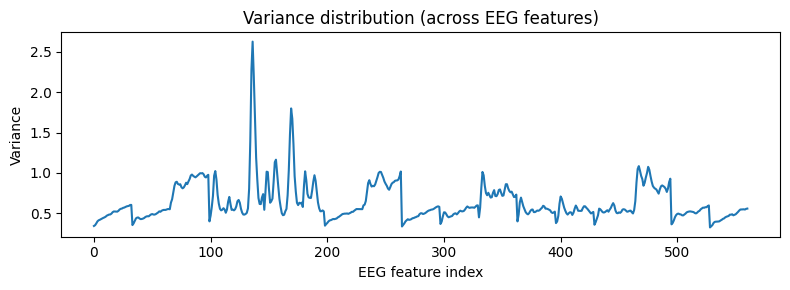

In [55]:
import matplotlib.pyplot as plt

#variance distribution
X = brain_seen.numpy()
var = X.var(axis=0)

plt.figure(figsize=(8,3))
plt.plot(var)
plt.xlabel("EEG feature index")
plt.ylabel("Variance")
plt.title("Variance distribution (across EEG features)")
plt.tight_layout()

plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/Variance_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

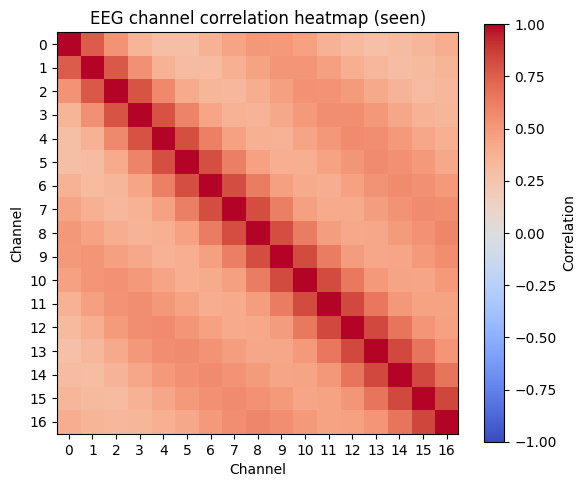

In [56]:
#Channel correlation heatmap

#join timepoints across all trials for each channel
chan_signals = []
for ch in range(17):
    chan_signals.append(X[:, ch].reshape(-1))

corr = np.corrcoef(chan_signals)

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(17))
plt.yticks(range(17))
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.title('EEG channel correlation heatmap (seen)')
plt.tight_layout()

plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/EEG_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

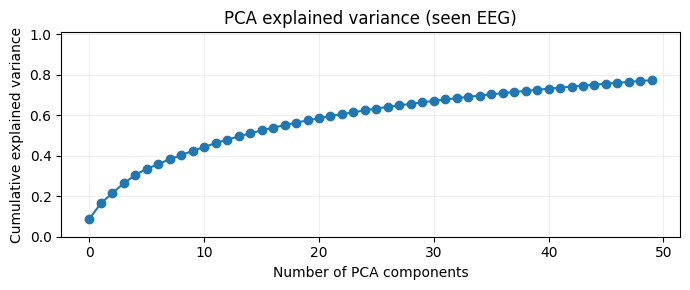

In [57]:
#EEG channels exhibits non-trivial correlations -> structured signal -> ML appropriate

#PCA variance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = brain_seen.numpy().reshape(brain_seen.shape[0], -1)
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=50)
pca.fit(X)

cu = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(7,3))
plt.plot(cu, marker='o')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA explained variance (seen EEG)')
plt.ylim(0, 1.01)
plt.grid(True, alpha=0.2)
plt.tight_layout()

plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/PCA_variance.png", dpi=300, bbox_inches="tight")
plt.show()


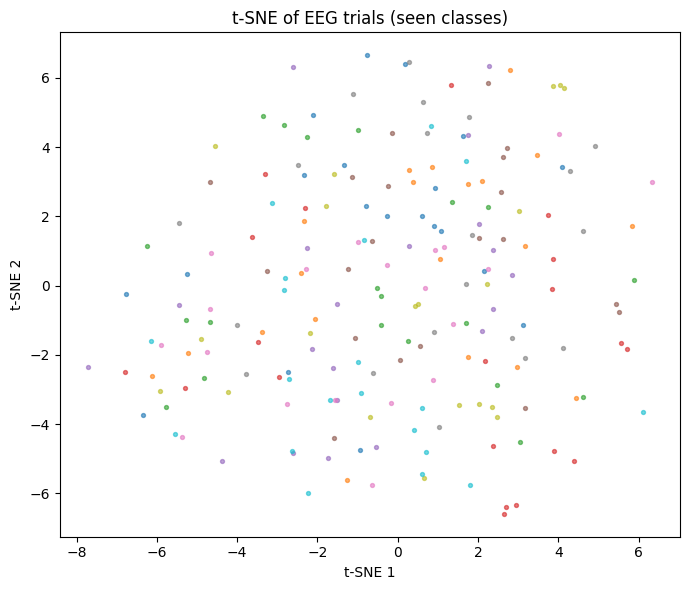

In [58]:
#shows lower dimensional structure (good motivation for embeddings + refinement)

#t-SNE EEG trials (seen)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

X = brain_seen.numpy().reshape(brain_seen.shape[0], -1)
y = label_seen.numpy().squeeze().astype(int)

K = 20
classes = np.unique(y)[:K]

mask = np.isin(y, classes)
X = X[mask]
y = y[mask]

#standardise then t-SNE
X = StandardScaler().fit_transform(X)
Z = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=0).fit_transform(X)

plt.figure(figsize=(7,6))
for c in np.unique(y):
    plt.scatter(Z[y==c, 0], Z[y==c, 1], s=8, alpha=0.6, label=str(c))

plt.title("t-SNE of EEG trials (seen classes)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()

plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/t-SNE_EDA.png", dpi=300, bbox_inches="tight")
plt.show()
